In [2]:
from collections import OrderedDict
from concurrent.futures import ThreadPoolExecutor, as_completed

import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Download the data

In [3]:
from collections import defaultdict


api = wandb.Api()
target_names = ["gaussian_mixture40", "many_well"]# , "planar_robot_4goal", "gaussian_mixture40"]
dims = [5, 32]

algorithm_names = [
    "gfnpiwbuf_tgtess0.0",
    "gfnpiwbuf_tgtess0.01",
    "gfnpiwbuf_tgtess0.02",
    "gfnpiwbuf",  # 0.05
    "gfnpiwbuf_tgtess0.1",
    "gfnpiwbuf_tgtess0.2",
    "gfnpiwbuf_tgtess0.5",
    "gfnpiwbuf_tgtess0.8",
    "gfnpiwbuf_tgtess0.9",
    "gfnpiwbuf_tgtess0.99",
    "gfnsmcpiwbuf_tgtess0.0",
    "gfnsmcpiwbuf_tgtess0.01",
    "gfnsmcpiwbuf_tgtess0.02",
    "gfnsmcpiwbuf_flowdim64",  # 0.05
    "gfnsmcpiwbuf_tgtess0.1",
    "gfnsmcpiwbuf_tgtess0.2",
    "gfnsmcpiwbuf_tgtess0.5",
    "gfnsmcpiwbuf_tgtess0.8",
    "gfnsmcpiwbuf_tgtess0.9",
    "gfnsmcpiwbuf_tgtess0.99",
]

wandb_tag_filter = {
    "$all": ["ablation_tgtess"],
    "$nin": ["hidden", "legacy"],
}

wandb_filter = {
    "tags": wandb_tag_filter,
}

runs = defaultdict(dict)

# first key is target_name-dim
for target_name, dim in zip(target_names, dims):
    wandb_filter["config.target_name"] = target_name
    wandb_filter["config.target_dim"] = dim

    for algorithm_name in algorithm_names:
        wandb_filter["config.wandb_name"] = algorithm_name

        if algorithm_name in ["gfnsmcpiwbuf", "gfnsmcpiwbuf_flowdim64"]:
            algorithm_name = "gfnsmcpiwbuf_tgtess0.05"
        elif algorithm_name in ["gfnpiwbuf"]:
            algorithm_name = "gfnpiwbuf_tgtess0.05"

        if len(runs[f"{target_name}-{dim}d"].get(algorithm_name, dict())) > 0:
            continue

        runs[f"{target_name}-{dim}d"][algorithm_name] = api.runs(f"sanghyeok-choi/sampling_bench", filters=wandb_filter)
        print(f"Number of runs in {target_name}-{dim}d/{algorithm_name}: {len(runs[f'{target_name}-{dim}d'][algorithm_name])}")


Number of runs in gaussian_mixture40-5d/gfnpiwbuf_tgtess0.0: 5
Number of runs in gaussian_mixture40-5d/gfnpiwbuf_tgtess0.01: 5
Number of runs in gaussian_mixture40-5d/gfnpiwbuf_tgtess0.02: 5
Number of runs in gaussian_mixture40-5d/gfnpiwbuf_tgtess0.05: 5
Number of runs in gaussian_mixture40-5d/gfnpiwbuf_tgtess0.1: 5
Number of runs in gaussian_mixture40-5d/gfnpiwbuf_tgtess0.2: 5
Number of runs in gaussian_mixture40-5d/gfnpiwbuf_tgtess0.5: 5
Number of runs in gaussian_mixture40-5d/gfnpiwbuf_tgtess0.8: 5
Number of runs in gaussian_mixture40-5d/gfnpiwbuf_tgtess0.9: 5
Number of runs in gaussian_mixture40-5d/gfnpiwbuf_tgtess0.99: 5
Number of runs in gaussian_mixture40-5d/gfnsmcpiwbuf_tgtess0.0: 5
Number of runs in gaussian_mixture40-5d/gfnsmcpiwbuf_tgtess0.01: 5
Number of runs in gaussian_mixture40-5d/gfnsmcpiwbuf_tgtess0.02: 5
Number of runs in gaussian_mixture40-5d/gfnsmcpiwbuf_tgtess0.05: 5
Number of runs in gaussian_mixture40-5d/gfnsmcpiwbuf_tgtess0.1: 5
Number of runs in gaussian_mixtur

In [4]:
### Prepare dataframes

# Prepare metrics (columns)
metrics = ["KL/eubo", "KL/elbo", "logZ/reverse", "discrepancies/sd", "KL/eubo-elbo"]
metrics_std = [f"{m}_std" for m in metrics]
metrics_min = [f"{m}_min" for m in metrics]
metrics_max = [f"{m}_max" for m in metrics]

# make a dataframe with group_keys as multi-index and metrics as columns
metrics_dfs = {}
for target_name_dim in runs.keys():
    # row is algorithm_name
    # column is metrics_columns
    metrics_dfs[target_name_dim] = pd.DataFrame(columns=metrics + metrics_std + metrics_min + metrics_max) 

In [5]:

def process_group_key(alg_name, alg_runs, metrics, timesteps, n_seeds):
    # Save to numpy array first
    metrics_arr = np.zeros((n_seeds, len(metrics)))

    metrics_wo_gap = [m for m in metrics if m != "KL/eubo-elbo"]
    for i, run in enumerate(alg_runs):
        # Fetch last 5 metrics
        last_5_df = run.history(samples=timesteps[-1] + 1, keys=metrics_wo_gap)
        last_5_df.set_index("_step", inplace=True)
        last_5_values = last_5_df.loc[timesteps, metrics_wo_gap]
        last_5_values.loc[:, "KL/eubo-elbo"] = last_5_values["KL/eubo"] - last_5_values["KL/elbo"]
        metrics_arr[i] = last_5_values.values.mean(axis=0)

    return {
        'key': alg_name,
        'mean': metrics_arr.mean(axis=0),  # average over 5 seeds
        'std': metrics_arr.std(axis=0),  # std over 5 seeds
        'min': metrics_arr.min(axis=0),  # min over 5 seeds
        'max': metrics_arr.max(axis=0),  # max over 5 seeds
    }


last_5_timesteps = [19200, 19400, 19600, 19800, 19999]  # to be averaged
n_seeds = 5

for target_name_dim in runs.keys():
    print(f"Downloading runs for {target_name_dim}")

    target_runs = runs[target_name_dim]
    keys = target_runs.keys()
    with ThreadPoolExecutor(max_workers=min(32, len(runs[target_name_dim]))) as executor:
        futures = {
            executor.submit(
                process_group_key, 
                key,
                target_runs[key],
                metrics,
                [19200, 19400, 19600, 19800, 19999] if target_name_dim in ["gaussian_mixture40-5d", "many_well-32d"] else [38400, 38800, 39200, 39600, 39999],
                n_seeds,
            ): key for key in keys
        }

        for future in as_completed(futures):
            result = future.result()
            key = result['key']

            # Store results in dataframes
            metrics_dfs[target_name_dim].loc[key, metrics] = result['mean']
            metrics_dfs[target_name_dim].loc[key, metrics_std] = result['std']
            metrics_dfs[target_name_dim].loc[key, metrics_min] = result['min']
            metrics_dfs[target_name_dim].loc[key, metrics_max] = result['max']

### Main Results

In [6]:
def print_latex_table(
    target_names: list[str],
    target_names_to_display_name: dict[str, str],
    metrics: list[str],
    metric_names: list[str],
    final_metrics_dfs: dict[str, pd.DataFrame],
):
    # header = f"{'Algorithm': <150}"
    # for target_name in target_names:
    #     name, dim = target_name.replace('_', '').split('-')
    #     for metric_name in metric_names:
    #         col = f"{name.upper()}({dim}) {metric_name}"
    #         header += f" & {col: <24}"
    # header += "\\\\"
    # print(header)

    # Print latex table with column: target_names[0]-elbo & target_names[0]-eubo & target_names[1]-elbo & energy_names[1]-eubo & ...
    indices = final_metrics_dfs[target_names[0]].index
    for df in final_metrics_dfs.values():
        if not np.all(df.index == indices):
            raise ValueError("All dataframes must have the same index")

    out = f"{'Algorithm': <20}"
    for target_name in target_names:
        for metric_name in metric_names:
            col = f"{target_names_to_display_name[target_name]} {metric_name}"
            out += f" & {col: <24}"
    out += "\n"

    for idx in indices:
        out += f"{idx: <20}\n"
        for target_name in target_names:
            temp_df = final_metrics_dfs[target_name].loc[idx]
            temp_df = final_metrics_dfs[target_name].loc[idx]
            for metric in metrics:
                val, std = temp_df[metric], temp_df[f"{metric}_std"]
                if val < -1e4 or val > 1e4:
                    # Convert to scientific notation
                    record = f"{val:.2e}\scriptsize$\pm${std:0.2e} \n"
                else:
                    record = f"{val:0.2f}\scriptsize$\pm${std:0.2f} \n"
                out += f"\t& {record: <24}"
        out += "\\\\"
        out += "\n"
    print(out)
    

analysis_name = "main"
lp = [False]

report_metrics = ["discrepancies/sd"]#, "discrepancies/sd"]
report_metric_names = ["Sinkhorn"]#, "Sinkhorn"]
# metrics = ["KL/eubo-elbo", "discrepancies/sd"]
# metric_names = ["EUBO-ELBO", "Sinkhorn"]

# run_name_to_display_name = OrderedDict({
#     "gfnpiwbuf_tgtess0.0": "0.0",
#     "gfnpiwbuf_tgtess0.01": "0.01",
#     "gfnpiwbuf_tgtess0.02": "0.02",
#     "gfnpiwbuf_tgtess0.05": "0.05",
#     "gfnpiwbuf_tgtess0.1": "0.1",
#     "gfnpiwbuf_tgtess0.2": "0.2",
#     "gfnpiwbuf_tgtess0.5": "0.5",
#     "gfnpiwbuf_tgtess0.8": "0.8",
#     "gfnpiwbuf_tgtess0.9": "0.9",
#     "gfnpiwbuf_tgtess0.99": "0.99",
#     "gfnsmcpiwbuf_tgtess0.0": "0.0",
#     "gfnsmcpiwbuf_tgtess0.01": "0.01",
#     "gfnsmcpiwbuf_tgtess0.02": "0.02",
#     "gfnsmcpiwbuf_tgtess0.05": "0.05",
#     "gfnsmcpiwbuf_tgtess0.1": "0.1",
#     "gfnsmcpiwbuf_tgtess0.2": "0.2",
#     "gfnsmcpiwbuf_tgtess0.5": "0.5",
#     "gfnsmcpiwbuf_tgtess0.8": "0.8",
#     "gfnsmcpiwbuf_tgtess0.9": "0.9",
#     "gfnsmcpiwbuf_tgtess0.99": "0.99",
# })

run_name_order = [
    "gfnpiwbuf_tgtess0.0",
    "gfnpiwbuf_tgtess0.01",
    "gfnpiwbuf_tgtess0.02",
    "gfnpiwbuf_tgtess0.05",
    "gfnpiwbuf_tgtess0.1",
    "gfnpiwbuf_tgtess0.2",
    "gfnpiwbuf_tgtess0.5",
    "gfnpiwbuf_tgtess0.8",
    "gfnpiwbuf_tgtess0.9",
    "gfnpiwbuf_tgtess0.99",
    "gfnsmcpiwbuf_tgtess0.0",
    "gfnsmcpiwbuf_tgtess0.01",
    "gfnsmcpiwbuf_tgtess0.02",
    "gfnsmcpiwbuf_tgtess0.05",
    "gfnsmcpiwbuf_tgtess0.1",
    "gfnsmcpiwbuf_tgtess0.2",
    "gfnsmcpiwbuf_tgtess0.5",
    "gfnsmcpiwbuf_tgtess0.8",
    "gfnsmcpiwbuf_tgtess0.9",
    "gfnsmcpiwbuf_tgtess0.99",
]

target_names_to_display_name = {
    "gaussian_mixture40-2d": "GMM40 (2d)",
    "gaussian_mixture40-5d": "GMM40 (5d)",
    "gaussian_mixture40-50d": "GMM40 (50d)",
    "funnel-10d": "Funnel (10d)",
    "many_well-32d": "Many Well (32d)",
    "many_well-64d": "Many Well (64d)",
}

new_dfs = {key: df.copy() for key, df in metrics_dfs.items()}
for key, df in new_dfs.items():
    # df.index = df.index.map(run_name_to_display_name)
    # # Filter out keys that are not in run_name_to_display_name
    # df = df[df.index.isin(list(run_name_to_display_name.values()))]
    # print(run_name_to_display_name.values())
    df = df.reindex(run_name_order)
    new_dfs[key] = df

# save_final_metrics_dfs_to_csv(energy_names, metrics, metric_names, new_df, analysis_name)
print_latex_table(
    list(runs.keys()),
    target_names_to_display_name,
    report_metrics,
    report_metric_names,
    new_dfs,
)


Algorithm            & GMM40 (5d) Sinkhorn      & Many Well (32d) Sinkhorn
gfnpiwbuf_tgtess0.0 
	& 2012.73\scriptsize$\pm$478.48 
	& 36.94\scriptsize$\pm$2.90 
\\
gfnpiwbuf_tgtess0.01
	& 2695.43\scriptsize$\pm$168.93 
	& 23.29\scriptsize$\pm$0.29 
\\
gfnpiwbuf_tgtess0.02
	& 2749.93\scriptsize$\pm$119.37 
	& 23.06\scriptsize$\pm$0.10 
\\
gfnpiwbuf_tgtess0.05
	& 2813.90\scriptsize$\pm$133.10 
	& 22.97\scriptsize$\pm$0.02 
\\
gfnpiwbuf_tgtess0.1 
	& 2880.44\scriptsize$\pm$144.62 
	& 22.91\scriptsize$\pm$0.03 
\\
gfnpiwbuf_tgtess0.2 
	& 3116.39\scriptsize$\pm$395.75 
	& 22.86\scriptsize$\pm$0.02 
\\
gfnpiwbuf_tgtess0.5 
	& 3338.69\scriptsize$\pm$219.90 
	& 22.82\scriptsize$\pm$0.03 
\\
gfnpiwbuf_tgtess0.8 
	& 3543.13\scriptsize$\pm$556.70 
	& 22.79\scriptsize$\pm$0.02 
\\
gfnpiwbuf_tgtess0.9 
	& 3403.16\scriptsize$\pm$233.26 
	& 22.78\scriptsize$\pm$0.03 
\\
gfnpiwbuf_tgtess0.99
	& 3108.26\scriptsize$\pm$123.53 
	& 22.56\scriptsize$\pm$0.07 
\\
gfnsmcpiwbuf_tgtess0.0
	& 81.75\scriptsize$\p

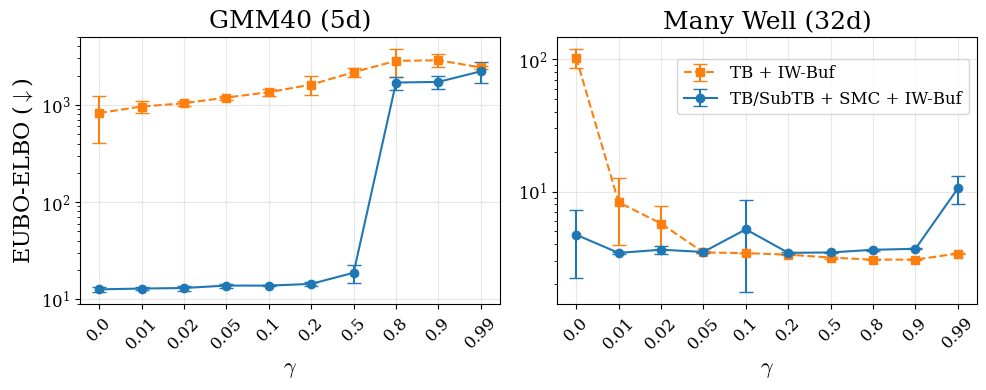

In [7]:
# from matplotlib.font_manager import FontProperties

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['mathtext.fontset'] = "cm"

import matplotlib.ticker as mticker

tgtess_list = [0.0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]
x_idx = list(range(len(tgtess_list)))

# ELBO / EUBO plots per target_name from `new_dfs`
# Assumes `new_dfs` is a dict[target_name -> DataFrame]
# with index = target_ess strings (e.g., '0.0', '0.01', ..., '0.99')
# and columns: 'KL/eubo-elbo', 'discrepancies/sd', 'KL/eubo-elbo_std', 'discrepancies/sd_std'

if 'new_dfs' not in globals():
    raise RuntimeError("`new_dfs` not found. Run the previous cells that build `new_dfs`.")

required_cols = ['KL/eubo-elbo', 'discrepancies/sd']
std_cols = ['KL/eubo-elbo_std', 'discrepancies/sd_std']

fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

for i, ((target_name, df), ax) in enumerate(zip(new_dfs.items(), axes)):
    if df is None or len(df) == 0:
        continue

    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in dataframe for {target_name}: {missing}")

    # EUBO-ELBO

    # First, gfnpiwbuf_tgtess*
    iwbuf_y_elbo = df.loc[df.index.str.startswith('gfnpiwbuf_tgtess'), 'KL/eubo-elbo'].astype(float).to_numpy()
    iwbuf_yerr_elbo = df.loc[df.index.str.startswith('gfnpiwbuf_tgtess'), 'KL/eubo-elbo_std'].astype(float).to_numpy()
    ax.errorbar(
        x_idx, iwbuf_y_elbo, yerr=iwbuf_yerr_elbo, marker='s', linestyle='--', capsize=5, color='tab:orange',
        label='TB + IW-Buf'
    )

    # Then, gfnsmcpiwbuf_tgtess*
    smcpiwbuf_y_elbo = df.loc[df.index.str.startswith('gfnsmcpiwbuf_tgtess'), 'KL/eubo-elbo'].astype(float).to_numpy()
    smcpiwbuf_yerr_elbo = df.loc[df.index.str.startswith('gfnsmcpiwbuf_tgtess'), 'KL/eubo-elbo_std'].astype(float).to_numpy()
    ax.errorbar(x_idx, smcpiwbuf_y_elbo, yerr=smcpiwbuf_yerr_elbo, marker='o', linestyle='-', capsize=5, color='tab:blue',
        label='TB/SubTB + SMC + IW-Buf'
    )

    # # yerr_elbo = df['KL/eubo-elbo_std'].astype(float).to_numpy()
    # # ax.errorbar(x_idx, y_elbo, yerr=yerr_elbo, marker='s', linestyle='--', capsize=5, color='tab:blue')
    # y_elbo_min = df['KL/eubo-elbo_min'].astype(float).to_numpy()
    # y_elbo_max = df['KL/eubo-elbo_max'].astype(float).to_numpy()
    # ax.plot(x_idx, y_elbo, marker='s', linestyle='--', color='tab:blue')
    # ax.fill_between(x_idx, y_elbo_min, y_elbo_max, alpha=0.2, color='tab:blue')

    ax.set_title(target_names_to_display_name[target_name], fontsize=18)
    if i == 0:
        ax.set_ylabel("EUBO-ELBO ($\\downarrow$)", fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

    # # Sinkhorn
    # y_eubo = df['discrepancies/sd'].astype(float).to_numpy()
    # yerr_eubo = df['discrepancies/sd_std'].astype(float).to_numpy()
    # axes[1].errorbar(x_idx, y_eubo, yerr=yerr_eubo, marker='o', linestyle='-', capsize=3, color='tab:orange')
    # axes[1].set_title('Sinkhorn ($\\downarrow$)')
    # axes[1].grid(True, alpha=0.3)
    # axes[1].set_yscale('log')

    # # Set x ticks/labels as the original string labels
    # for ax in axes:
    ax.set_xticks(x_idx)
    ax.set_xticklabels(tgtess_list, rotation=45)
    ax.set_xlabel(r"$\gamma$", fontsize=16)

    # Set font size of tick labels
    ax.tick_params(axis='both', which='major', labelsize=12)

    if i == 1:
        ax.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1.0, 0.95))

# fig.suptitle("EUBO-ELBO ($\\downarrow$)",fontsize=16)
fig.tight_layout()
plt.show()

fig.savefig("./ablation_gamma.pdf", dpi=300)